In [3]:
from dotenv import load_dotenv, find_dotenv 

load_dotenv(find_dotenv(), override = True)

True

In [4]:
from langchain_exa import ExaSearchRetriever
from langchain_openai import ChatOpenAI 

exa_search_retriever = ExaSearchRetriever(k = 1, highlights = False, type = "keyword") 

llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0)

In [5]:
from langchain_groq import ChatGroq 

llm_groq_8b = ChatGroq(model = "llama-3.1-8b-instant", temperature = 0)
llm_groq_70b = ChatGroq(model = "llama-3.1-70b-versatile", temperature = 0)

In [6]:
from typing_extensions import TypedDict 
from typing import Annotated 
from operator import add 

class Custom_State(TypedDict): 
    thesis: str 
    thesis_parts: Annotated[list[str], add]
    context: Annotated[list[str], add] 
    recent_thesis_part: str
    iteration_counter: int
    final_response: str

# exa_search_node

In [7]:
def exa_search_node_new_1(state: Custom_State):
    """Search for context from online sources. 
    This search should use the entire recent_thesis_part 
    This tool should return context for the question that was asked and the accompanying url for the context. 
    Include the url at the end of the context on a new line.
    
    Args: 
        recent_thesis_part: recent_thesis_part
    """
    exa_search_retriever_new = ExaSearchRetriever(k = 1, highlights = False, type = "autotype")
    output = exa_search_retriever_new.invoke(state["thesis_parts"][0]) 
    return {"context": [f"Information from source 1:\n\n" + output[0].page_content + "\n\n" + "Source URL: \n\n" + output[0].metadata["url"] + "\n\n" + ("-" * 100) + "\n\n"]}

In [8]:
def exa_search_node_new_2(state: Custom_State):
    """Search for context from online sources. 
    This search should use the entire recent_thesis_part 
    This tool should return context for the question that was asked and the accompanying url for the context. 
    Include the url at the end of the context on a new line.
    
    Args: 
        recent_thesis_part: recent_thesis_part
    """
    exa_search_retriever_new = ExaSearchRetriever(k = 1, highlights = False, type = "autotype")
    output = exa_search_retriever_new.invoke(state["thesis_parts"][1]) 
    return {"context": [f"Information from source 2:\n\n" + output[0].page_content + "\n\n" + "Source URL: \n\n" + output[0].metadata["url"] + "\n\n" + ("-" * 100) + "\n\n"]}

In [9]:
def exa_search_node_new_3(state: Custom_State):
    """Search for context from online sources. 
    This search should use the entire recent_thesis_part 
    This tool should return context for the question that was asked and the accompanying url for the context. 
    Include the url at the end of the context on a new line.
    
    Args: 
        recent_thesis_part: recent_thesis_part
    """
    exa_search_retriever_new = ExaSearchRetriever(k = 1, highlights = False, type = "autotype")
    output = exa_search_retriever_new.invoke(state["thesis_parts"][2]) 
    return {"context": [f"Information from source 3:\n\n" + output[0].page_content + "\n\n" + "Source URL: \n\n" + output[0].metadata["url"] + "\n\n" + ("-" * 100) + "\n\n"]}

# Adding a Structured Output to query_parsing_node

In [10]:
from pydantic import BaseModel, Field 
from typing import Optional

class parsed_query(BaseModel): 
    """The original thesis statement split into its parts.""" 
    thesis_part_1: str = Field(description = "Thesis that has been split into its main idea/main argument and first sub-argument/reasoning.") 
    thesis_part_2: str = Field(description = "Thesis that has been split into its main idea/main argument and second sub-argument/reasoning.")
    thesis_part_3: Optional[str] = Field(description = "Thesis that has been split into its main idea/main argument and third sub-argument/reasoning.")

In [11]:
# llm_2 = ChatOpenAI(model = "gpt-4o", temperature = 0) 

llm_structured = llm_groq_8b.with_structured_output(parsed_query)

# query_parsing_node

In [12]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import SystemMessage, HumanMessage

def query_parsing_node(state: Custom_State): 
    thesis = state["thesis"] 
    prompt_template = ChatPromptTemplate.from_template("""
        The overall goal of this LLM application is to help a user in writing their research paper based on their thesis statement that they provide. 
        However, this is the first step of the process in which you must parse the original, whole thesis into seperate sentences. 
        This will require you to analyze the thesis statement, locate its main idea as well as its sub-arguemnts/reasonings, and finally, combine the main idea with ONE of the sub-arguemnts/reasonings in each sentence. 
        Therefore, IF the original thesis statement included a main idea and 2 sub-arguments/reasonings, the final output must include 2 seperate sentences, each including the main idea and a unique sub-argument/reasoning. 
        DO NOT INCLUDE quotation marks "" in the final output. 
                                                       
        ---START OF EXAMPLES---
                                                       
        For some guidance, consider the following examples: 
                                                       
        Example 1:
                                                       
        Original thesis statement: "Mandatory school uniforms should be implemented in educational institutions as they promote a sense of equality, reduce distractions, and foster a focused and professional learning environment." 
                                                       
        Output: 
            "Mandatory school uniforms should be implemented in educational institutions as they promote a sense of equality."
            "Mandatory school uniforms should be implemented in educational institutions as they reduce distractions."
            "Mandatory school uniforms should be implemented in educational institutions as they foster a focused and professional learning environment."
                                                            
        Example 2: 
                                                        
        Original thesis statement: "Globalization has created a world more interconnected than ever before, yet it also amplifies economic disparities and cultural homogenization."
                                                        
        Output: 
            "Globalization has created a world more interconnected than ever before, yet it also amplifies economic disparities."
            "Globalization has created a world more interconnected than ever before, yet it also amplifies cultural homogenization."  
                                                            
        Example 3: 
        
        Original thesis statement: "Immigration enriches receiving countries culturally and economically, outweighing any perceived social or economic burdens." 
                                                        
        Output: 
            "Immigration enriches receiving countries culturally, outweighing any perceived social or economic burdens." 
            "Immigration enriches receiving countries economically, outweighing any perceived social or economic burdens."
                                                            
        -----END OF EXAMPLES-----
                                                        
        Original thesis statement: 
        
        {thesis}
        """)
    
    query_parsing_chain = prompt_template | llm_structured 
    parsed_thesis = query_parsing_chain.invoke({"thesis": thesis[0].content}) 
    return {"thesis_parts": [parsed_thesis.thesis_part_1, parsed_thesis.thesis_part_2, parsed_thesis.thesis_part_3], "iteration_counter": -1}
    

# text_and_quote_extractor_node

In [13]:
def text_and_quote_extractor_node(state: Custom_State): 
    context = state["context"] 
    original_thesis = state["thesis"] 
    len_context = len(context)
    context_str = "" 
    for i in context: 
        context_str += str(i)
    system_message_template = ChatPromptTemplate.from_template(template = """
        Given the original thesis statement below and all of the provided context, return reasoning as to why the websites, articles, or academic papers found through the web searchs assist the user in writing their research paper. 
        You must return SPECIFIC QUOTATIONS from the websites, articles, or academic papers themselves that the user can utilize within their own research paper. 
        Display all reasoning in a numbered list format with the urls for each piece of reasoning at the end of the line. 
        DO NOT write the user's research paper for them.
        VERY IMPORTANT, USE ONLY THE PROVIDED ORIGINAL THESIS AND CONTEXT, DO NOT RETRIEVE INFORMATION FROM YOUR OWN INTERNAL DATABASE
                                   
        ----------------------------------------------------------------------------------------------------------------------------------------------
        
        **IMPORTANT**
                              
        Original Thesis Statement: **{original_thesis}**
                                   
        Given Context: 
                                   
        {context}
        """)
    text_and_quote_extractor_chain = system_message_template | llm_groq_70b | StrOutputParser()
    return {"final_response": text_and_quote_extractor_chain.invoke({"original_thesis": original_thesis[0].content, "context": context_str, "len_context": len_context})}

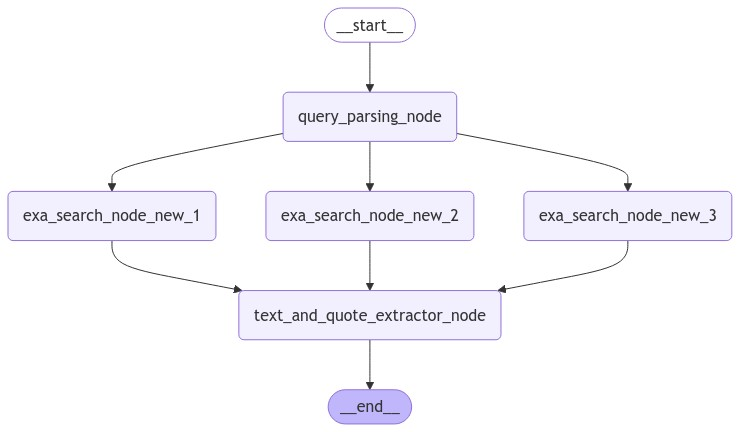

In [14]:
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode, tools_condition # tools_condition is not used here 
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END

builder = StateGraph(Custom_State) 

builder.add_node("query_parsing_node", query_parsing_node) 
# builder.add_node("assistant_node", assistant_node)
builder.add_node("exa_search_node_new_1", exa_search_node_new_1) 
builder.add_node("exa_search_node_new_2", exa_search_node_new_2) 
builder.add_node("exa_search_node_new_3", exa_search_node_new_3) 
# builder.add_node("remove_one_thesis_part_node", remove_one_thesis_part_node)
# builder.add_node("change_iteration_counter_node", change_iteration_counter_node)
builder.add_node("text_and_quote_extractor_node", text_and_quote_extractor_node)
# builder.add_node("load_thesis_part_node_new", load_thesis_part_node_new)

builder.add_edge(START, "query_parsing_node") 
builder.add_edge("query_parsing_node", "exa_search_node_new_1") 
builder.add_edge("query_parsing_node", "exa_search_node_new_2")
builder.add_edge("query_parsing_node", "exa_search_node_new_3")
builder.add_edge("exa_search_node_new_1", "text_and_quote_extractor_node")
builder.add_edge("exa_search_node_new_2", "text_and_quote_extractor_node")
builder.add_edge("exa_search_node_new_3", "text_and_quote_extractor_node")
builder.add_edge("text_and_quote_extractor_node", END)

graph = builder.compile(checkpointer = MemorySaver()) # interrupt_before = ["load_thesis_part_node"]

display(Image(graph.get_graph(xray = True).draw_mermaid_png()))

In [15]:
config = {"configurable": {"thread_id": "thesis_agent_example_2"}}

thesis_statement = [HumanMessage(content = "Mandatory school uniforms should be implemented in educational institutions as they promote a sense of equality, reduce distractions, and foster a focused and professional learning environment.")]
complete_message = graph.invoke({"thesis": thesis_statement}, config = config) 

print(complete_message) 
print("-" * 50) 
print(complete_message["final_response"])

{'thesis': [HumanMessage(content='Mandatory school uniforms should be implemented in educational institutions as they promote a sense of equality, reduce distractions, and foster a focused and professional learning environment.', additional_kwargs={}, response_metadata={})], 'thesis_parts': ['Mandatory school uniforms should be implemented in educational institutions as they promote a sense of equality', 'Mandatory school uniforms should be implemented in educational institutions as they reduce distractions', 'Mandatory school uniforms should be implemented in educational institutions as they foster a focused and professional learning environment'], 'context': ['Information from source 1:\n\nERIC Number: ED458695  Record Type: Non-Journal  Publication Date: 1999-Dec  Pages: 13  Abstractor: N/A  ISBN: N/A  ISSN: N/A  EISSN: N/A  The Influence of a Mandatory School Uniform Policy.  This essay examines the influence of a mandatory school-uniform dress code on academic achievement and disc

In [16]:
from pprint import pprint

state = graph.get_state(config) 
pprint(state)

StateSnapshot(values={'thesis': [HumanMessage(content='Mandatory school uniforms should be implemented in educational institutions as they promote a sense of equality, reduce distractions, and foster a focused and professional learning environment.', additional_kwargs={}, response_metadata={})], 'thesis_parts': ['Mandatory school uniforms should be implemented in educational institutions as they promote a sense of equality', 'Mandatory school uniforms should be implemented in educational institutions as they reduce distractions', 'Mandatory school uniforms should be implemented in educational institutions as they foster a focused and professional learning environment'], 'context': ['Information from source 1:\n\nERIC Number: ED458695  Record Type: Non-Journal  Publication Date: 1999-Dec  Pages: 13  Abstractor: N/A  ISBN: N/A  ISSN: N/A  EISSN: N/A  The Influence of a Mandatory School Uniform Policy.  This essay examines the influence of a mandatory school-uniform dress code on academic

In [17]:
import uuid 

id = uuid.uuid1() 

uuid_int = id.int

config_uuid = {"configurable": {"thread_id": f"thesis_agent_example_{uuid_int}"}}

thesis_statement = [HumanMessage(content = "Social media has revolutionized communication and societal interactions, but it also presents significant challenges related to privacy, mental health, and misinformation.")]
complete_message = graph.invoke({"thesis": thesis_statement}, config = config_uuid) 

print(complete_message) 
print("-" * 50) 
print(complete_message["final_response"])

{'thesis': [HumanMessage(content='Social media has revolutionized communication and societal interactions, but it also presents significant challenges related to privacy, mental health, and misinformation.', additional_kwargs={}, response_metadata={})], 'thesis_parts': ['Social media has revolutionized communication and societal interactions, but it also presents significant challenges related to privacy, mental health, and misinformation.', 'Social media has revolutionized communication and societal interactions, but it also presents significant challenges related to privacy and misinformation.', 'Social media has revolutionized communication and societal interactions, but it also presents significant challenges related to mental health and misinformation.'], 'context': ['Information from source 1:\n\nYou are growing up in a world where social media has always been a part of connecting with others, especially friends and classmates. Social media has made it possible to stay connected 